# Comparison with Oleh

In [139]:
%load_ext autoreload
%autoreload 2

In [140]:
%matplotlib inline
#%matplotlib notebook
import matplotlib.pyplot as plt

import skimage.io
import skimage.color
import skimage.transform
import skimage.morphology

from typing import List, Tuple
from typing import Optional
import numpy
from MODULES.namedtuple import Partition

### Open the files

In [68]:
image_file = "smFISH_stitched_OLEH.tif"
oleh_file = "smFISH-full_result_mask.tif"
luca_file = "segmentation_res800.tiff"

raw_img = skimage.img_as_float(skimage.exposure.rescale_intensity(skimage.io.imread(image_file)))
luca_img = skimage.io.imread(luca_file).astype(int)
oleh_img = skimage.io.imread(oleh_file).astype(int)

luca_labels_OLD, luca_ncell_OLD = skimage.morphology.label(luca_img, background=0, return_num=True)
oleh_labels, oleh_ncell = skimage.morphology.label(oleh_img, background=0, return_num=True)

print(raw_img.shape, raw_img.dtype)
print(luca_img.shape, luca_labels_OLD.dtype, luca_ncell_OLD)
print(oleh_img.shape, oleh_labels.dtype, oleh_ncell)

(21505, 21505) float64
(2688, 2688) int64 4669
(21505, 21505) int64 6975


### Upsample luca's labels to match size of Oleh's labels 


In [70]:
luca_labels = skimage.transform.resize(luca_labels_OLD, oleh_labels.shape,
                                       order=0, 
                                       clip=True, preserve_range=True).astype(int)
print(luca_labels.shape)

(21505, 21505)


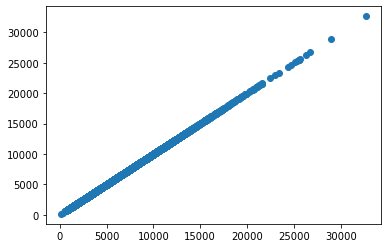

In [71]:
# Compute the areas and check nothing went worng during upsampling
luca_cells_area_OLD = numpy.bincount(luca_labels_OLD.flatten())[1:]
luca_cells_area = numpy.bincount(luca_labels.flatten())[1:]
oleh_cells_area = numpy.bincount(oleh_labels.flatten())[1:]

plt.scatter(oleh_cells_area,oleh_cells_area_OLD)

# Start the actual comparison

Based on:
1. luca_labels vs oleh_labels
2. luca_cells_area vs oleh_cells_area 

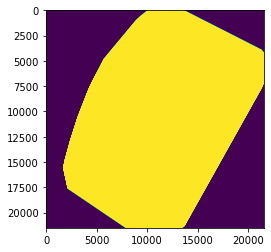

In [72]:
ROI_mask = skimage.morphology.convex_hull_image(luca_labels > 0)
plt.imshow(ROI_mask)

In [109]:
def contours_from_segmask(segmask, thickness: int=1):
    contours = (skimage.morphology.dilation(segmask)  != segmask)
    for i in range(1,thickness):
        contours = skimage.morphology.binary_dilation(contours)
    return contours


def add_red_contours(image, contours):
    if len(image.shape) == 2:
        image = skimage.img_as_float(skimage.color.gray2rgb(image))
    assert len(image.shape)==3
    image[contours == 1, 0] = 1
    image[contours == 1, 1:] = 0
    return image


def make_list_of_windows(ROI_mask: numpy.ndarray, n: int = 4, crop_size: int = 80):
    delta = 200
    window = list()
    while len(window)<n:
        iw = numpy.random.randint(low=0, high=ROI_mask.shape[0]-crop_size, size=1, dtype=int).item()
        ih = numpy.random.randint(low=0, high=ROI_mask.shape[1]-crop_size, size=1, dtype=int).item()
        if (ROI_mask[iw,ih] == 0) and (ROI_mask[iw+crop_size,ih] == 0) and \
           (ROI_mask[iw,ih+crop_size] == 0) and (ROI_mask[iw+crop_size,ih+crop_size] == 0):
            continue
        else:
            window.append((iw,ih,iw+crop_size,ih+crop_size))
    return window


def plot_comparison(raw_img, labels1, labels2, window: Optional[List[tuple]] = None, figsize: tuple =(24,24)):
    if window is None:
        window = [[0,0,img1.shape[0],img1.shape[1]]]
    
    n = len(window)
    if n>1:
        fig, axs = plt.subplots(nrows=n, ncols=2, figsize=figsize)
    else:
        fig, axs = plt.subplots(ncols=2, figsize=figsize)
        
    for row,w in enumerate(window):
        img = raw_img[w[0]:w[2],w[1]:w[3]]
        l1 = labels1[w[0]:w[2],w[1]:w[3]]
        l2 = labels2[w[0]:w[2],w[1]:w[3]]
        c1 = contours_from_segmask(l1, thickness=3)
        c2 = contours_from_segmask(l2, thickness=3)
        tmp1 = add_red_contours(img, c1)
        tmp2 = add_red_contours(img, c2)

        if n>1:
            axs[row,0].imshow(tmp1, aspect='equal')
            axs[row,1].imshow(tmp2, aspect='equal')
        else:
            axs[0].imshow(tmp1, aspect='equal')
            axs[1].imshow(tmp2, aspect='equal')

4


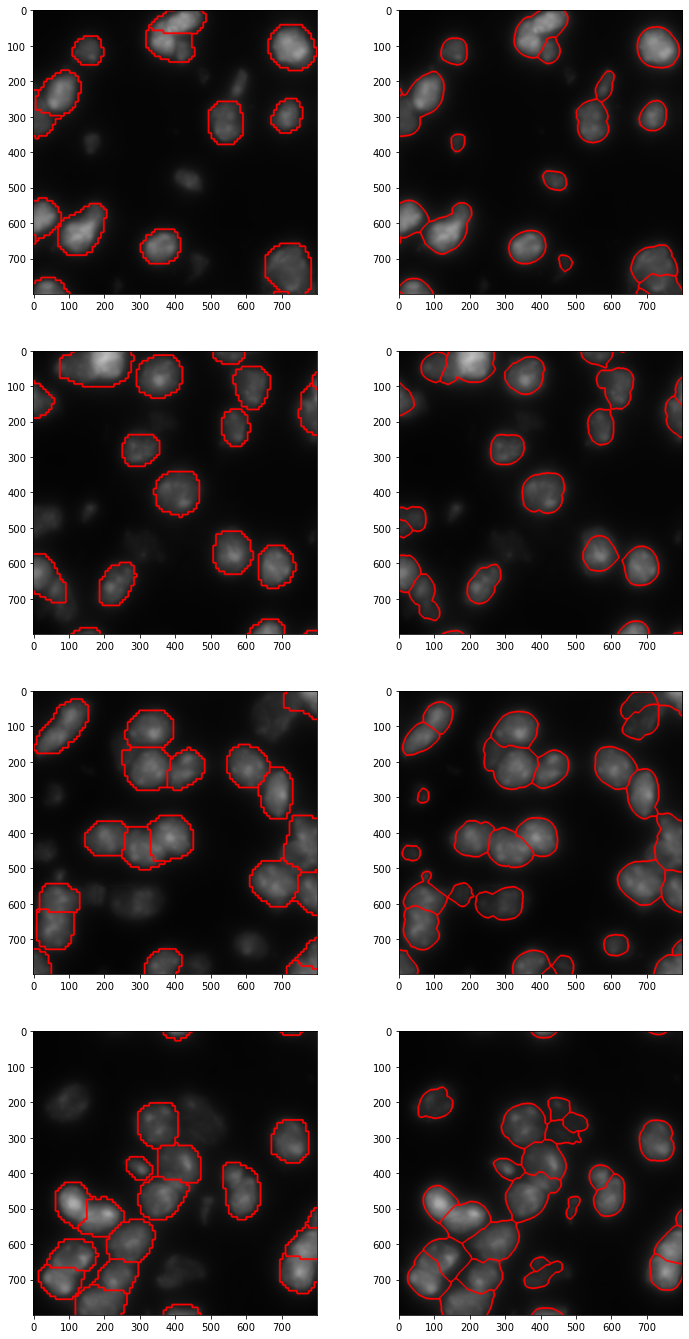

In [110]:
window = make_list_of_windows(ROI_mask, n=4, crop_size=800)
plot_comparison(raw_img, luca_labels, oleh_labels, window=window, figsize=(12,24))

total segmented area: luca, oleh 49139336 51842203


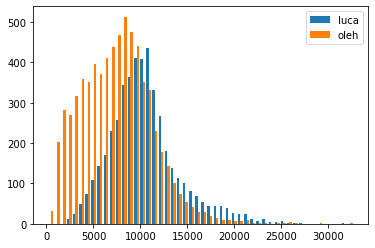

In [157]:
print("total segmented area: luca, oleh", luca_cells_area.sum(), oleh_cells_area.sum())
_ = plt.hist([luca_cells_area,oleh_cells_area], bins=50,label=["luca","oleh"])
_ = plt.legend()

1


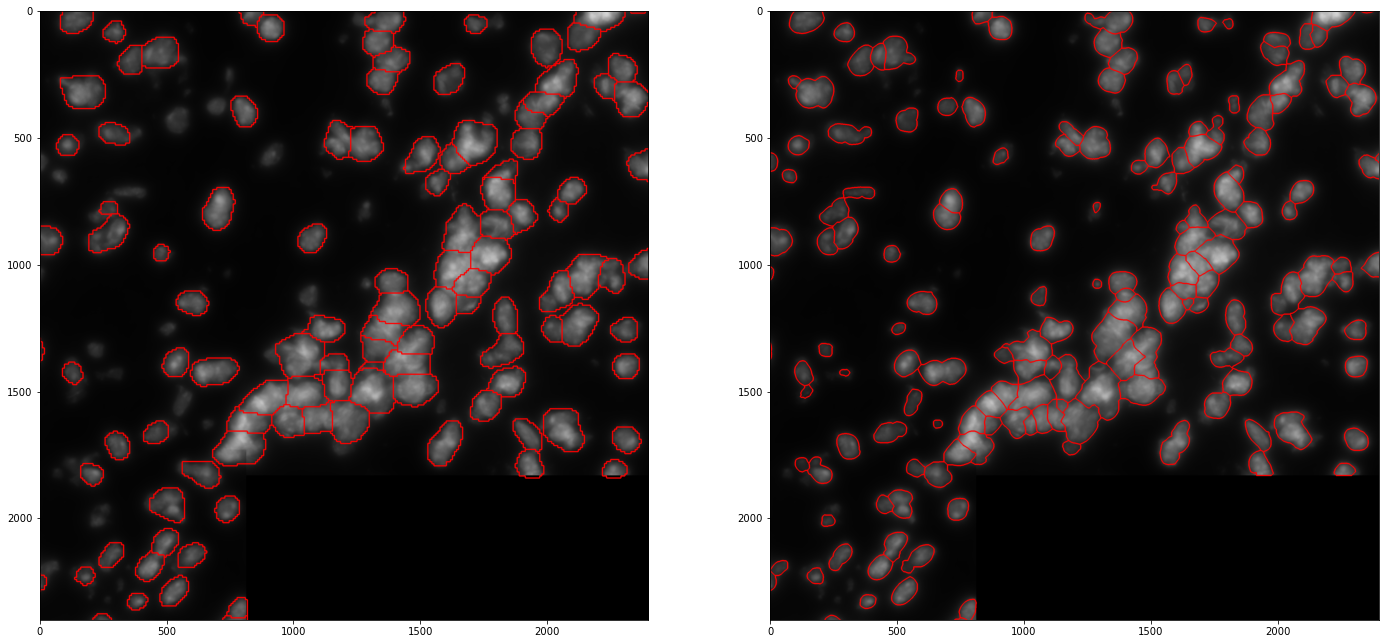

In [118]:
window = [(8*1000, 8*2100, 8*1300, 8*2400)]
plot_comparison(raw_img, luca_labels, oleh_labels, window=window, figsize=(24,24))

### Compute intersection over union

In [150]:
import torch 
window = (8*1000, 8*2100, 8*1300, 8*2400)
size = window[2]-window[0]
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

luca_membership = torch.from_numpy(luca_labels[window[0]:window[2],window[1]:window[3]]).flatten().to(device)
oleh_membership = torch.from_numpy(oleh_labels[window[0]:window[2],window[1]:window[3]]).flatten().to(device)
luca_sizes = torch.bincount(luca_membership)
oleh_sizes = torch.bincount(oleh_membership)

In [151]:
sizes, membership = Partition.compactify(luca_sizes, luca_membership)
luca_partition = Partition(which="luca",
                           membership=membership, # bg=0, fg=1,2,3,.....
                           sizes=sizes,
                           params={"ciap":"ciao"})

sizes, membership = Partition.compactify(oleh_sizes, oleh_membership)
oleh_partition = Partition(which="oleh",
                           membership=membership, # bg=0, fg=1,2,3,.....
                           sizes=sizes,
                           params={"ciap":"ciao"})

In [160]:
c_ol = oleh_partition.concordance_with_partition(luca_partition) 

In [159]:
c_lo = luca_partition.concordance_with_partition(oleh_partition) 

In [166]:
c_ol.iou

0.5523918867111206

In [165]:
c_lo.iou

0.5523918867111206

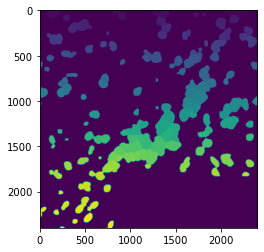

In [153]:
plt.imshow(oleh_partition.membership.view(size,size))

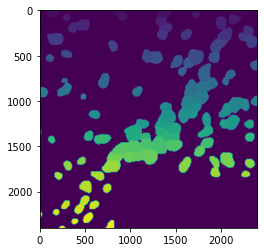

In [152]:
plt.imshow(luca_partition.membership.view(size,size))